In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSSSSBB'
meas='TOBS'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [10]:
measurements=['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS']

In [11]:
for name in measurements:
    eigvec = STAT[name]['eigvec']
    eigval = STAT[name]['eigval']


    # print sorted(eigval)

    pair = [(val, i) for i,val in enumerate(eigval)]

    pair.sort(key=lambda x: x[0])
    pair = pair[::-1]

    eigval_sorted = []
    eigvec_sorted = []
    for (val, i) in pair:
        eigval_sorted.append(val if val > 0 else 0)
#         eigval_sorted.append(val)
        eigvec_sorted.append(eigvec[:,i])
    STAT[name]['eigvec'] = (np.array(eigvec_sorted).T)
    STAT[name]['eigval'] = (np.array(eigval_sorted))

## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [12]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+-------------------+------------------+-------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|            coeff_1|           coeff_2|            coeff_3|           coeff_4|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|              res_4|           res_mean|    station|  total_var|undefs|              vector|  year|
+-------------------+------------------+-------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|-1073.8061998945723| 425.3767238176554|  42.68208887773061|3.3903781535373803|     81.7|SSSSSSBB| 33.6131|-114.5972|       TOBS|  0.

### Plot Mean and Eigenvecs

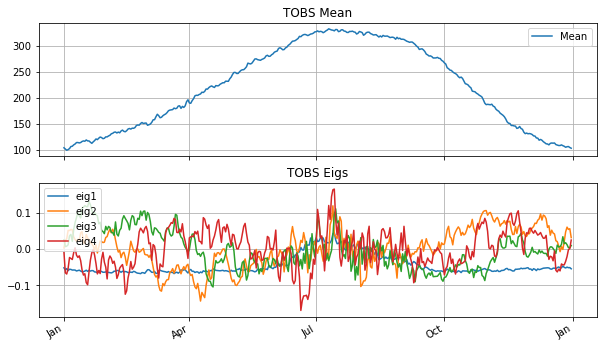

In [13]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

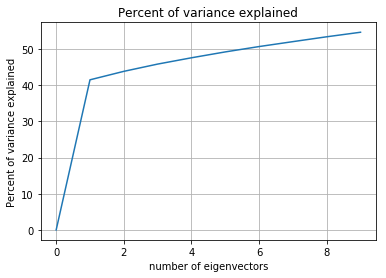

In [14]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [16]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

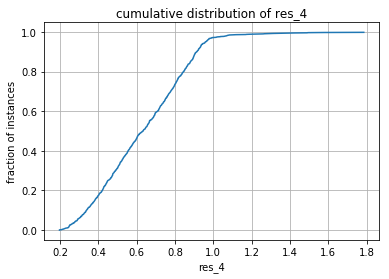

In [18]:
plot_CDF(df,'res_4')

In [28]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]
print rows[0]

(u'USC00040924', 1965.0, array([ 144.,  144.,  150.,  161.,  156.,  122.,  139.,  133.,  156.,
        183.,  183.,  172.,  222.,  211.,  178.,  244.,  261.,  233.,
        228.,  172.,  206.,  222.,  228.,  183.,  161.,  167.,  161.,
        228.,  233.,  250.,  278.,  244.,  239.,  256.,  256.,  244.,
        178.,  133.,  183.,  128.,  156.,  128.,  156.,  172.,  172.,
        178.,  183.,  228.,  222.,  267.,  267.,  278.,  278.,  194.,
        211.,  239.,  283.,  278.,  239.,  194.,  172.,  167.,  172.,
        217.,  244.,  222.,  244.,  211.,  200.,  183.,  194.,  211.,
        222.,  156.,  233.,  239.,  233.,  244.,  250.,  272.,  283.,
        233.,  211.,  233.,  250.,  244.,  250.,  272.,  289.,  294.,
        222.,  206.,  150.,  161.,  211.,  222.,  200.,  211.,  183.,
        183.,  172.,  183.,  211.,  250.,  278.,  306.,  328.,  333.,
        361.,  367.,  372.,  367.,  333.,  339.,  328.,  322.,  322.,
        344.,  367.,  378.,  361.,  311.,  250.,  267.,  283.,  2

In [20]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

40880

In [21]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [22]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [23]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00022790 7372
USW00023183 355
USC00043855 28037
USC00044259 13532
USC00027460 16613
USC00028112 16118
USC00027462 3239
USC00045502 8500
USC00028494 12765
USC00026865 8901
USC00029287 28153
USC00022787 6895
USC00042598 27989
USC00024977 16168
USC00022927 10392
USC00028499 12928
USC00021026 7523
USC00021361 3550
USC00020104 9190
USC00022462 11290
USC00020060 12079
USC00023852 2140
USC00026603 3476
USC00029634 9723
USC00028489 9461
USC00025467 23463
USC00021282 12077
USC00020949 14964
USC00027453 1428
USC00028641 4137
USC00029464 7493
USC00023573 2839
USW00093140 7232
USC00029015 347
USC00028566 1427
USC00021353 17314
USC00040924 4507
USC00021356 2877
USC00020406 1458
USC00025282 6611
USC00027661 3442
USC00021161 13858
USC00026246 704
USC00026476 1821
USC00046635 7009
USC00024829 23034
USC00045860 1420


In [24]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)


(47, 40880)


In [29]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

[ 33.          33.         -11.         ...,  63.83333333  57.8
  67.57142857]
total RMS                   =  239.053607275
RMS removing mean-by-station=  91.5339695568
RMS removing mean-by-day   =  44.7317940456


[-161. -161. -156. ...,  394.  394.  394.]


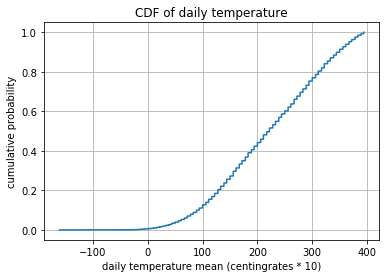

In [35]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
print NN
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of daily temperature')
xlabel('daily temperature mean (centingrates * 10)')
ylabel('cumulative probability')
# savefig('hw5_figures/daily_temp.png')

### Conclusions
It is likely to be hard to find correlations between the **amount** of rain on the same day in different stations. Because amounts of rain vary a lot between even close locations. It is more reasonable to try to compare whether or not it rained on the same day in different stations. As we see from the graph above, in our region it rains in about one third of the days.

### measuring statistical significance
We want to find a statistical test for rejecting the null hypothesis that says that the rainfall in the two locations is independent.

Using the inner product is too noisy, because you multiply the rainfall on the same day in two locations and that product can be very large - leading to a large variance and poor ability to discriminate.

An alternative is to ignore the amount of rain, and just ask whether it rained in both locations. We can then compute the probability associated with the number of overlaps under the null hypothesis.

Fix two stations. We restrict our attention to the days for which we have measurements for both stations, and define the following notation:
* $m$ : the total number of days (for which we have measurements for both stations).
* $n_1$ : the number of days that it rained on station 1
* $n_2$ : the number of days that it rained on station 2
* $l$ : the number of days that it rained on both stations.

We want to calculate the probability that the number of overlap days is $l$ given $m,n_1,n_2$.

The answer is:
$$
P = {m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} /{m \choose n_1}{m \choose n_2}
$$

Where
$$
{m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} = \frac{m!}{l! (n_1-l)! (n_2-l)! (m-n_1-n_2+l)!}
$$

We use the fact that $\Gamma(n+1) = n!$ and denote $G(n) \doteq \log \Gamma(n+1)$
$$
\log P = \left[G(m) - G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) \right] - 
\left[G(m)-G(n_1)-G(m-n_1)\right] - \left[G(m)-G(n_2)-G(m-n_2)\right]
$$
Which slightly simplifies to 
$$
\log P = -G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) - G(m)+G(n_1)+G(m-n_1) +G(n_2)+G(m-n_2)
$$

The log probability scales with $m$ the length of the overlap. So to get a per-day significance we consider $
\frac{1}{m} \log P $

In [89]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
print LogProb(1000,0,500,500)
exp(LogProb(1000,0,500,500))

-0.689467261568


0.501843349103545

In [173]:
#USC00193270 21482
#USC00193702 28237
X=copy(All['USC00024829'])
Y=copy(All['USC00043855'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))


23034
28037
22809
22809


In [174]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>350
    YG=Y[G]>350
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
#     print m, l, n1, n2
    logprob=LogProb(m,l,n1,n2)
    # print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
print -computeLogProb(X,Y)[0]

0.0118735620606


### calculate the normalized log probability for each pair of stations.

In [175]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

            

0 1 2 3 4 5 6 7 8 9 10 11

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46


In [176]:
print Pvals[:2,:2]
print Length[:2,:2]
print P_norm[:2,:2]

[[ 0.  0.]
 [ 0.  0.]]
[[    0.  5161.]
 [ 5161.     0.]]
[[-0.4        -0.07140611]
 [-0.07140611 -0.4       ]]


(2209,) (1545,)


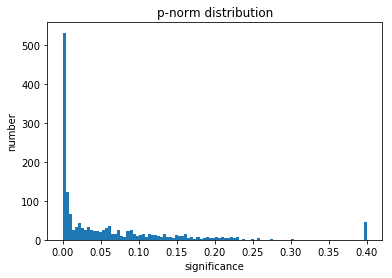

In [177]:
# A=P_norm.flatten();
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')
ylabel('number')
title('p-norm distribution')
# savefig('hw5_figures/p_norm_sig.png')

In [178]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)

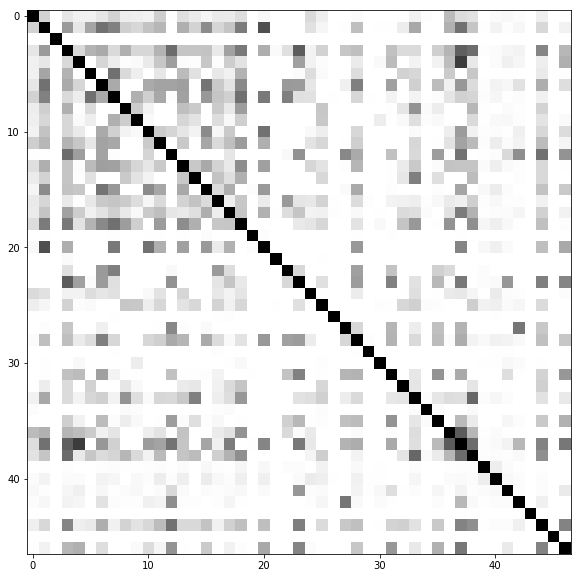

In [179]:
showmat(P_norm)

### Finding structure in the rependency matrix.
The matrix above shows, for each pair of stations, the normalized log probability that the overlap in rain days is random.

We see immediately the first 8 stations are highly correlatedwith each other. 

To find more correlations we use SVD (the term PCA is reserved for decomposition of the covariance matrix). As we shall see that the top 10 eigenvectors explain about 80% of the square magnitude of the matrix.

In [180]:
print 'A group of very correlated stations is:',All.keys()[:8]

A group of very correlated stations is: [u'USC00022790', u'USW00023183', u'USC00043855', u'USC00044259', u'USC00027460', u'USC00028112', u'USC00027462', u'USC00045502']


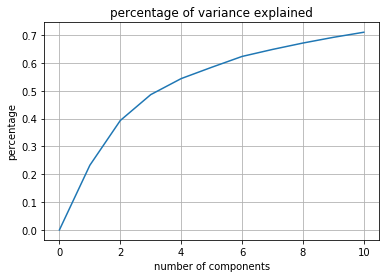

In [181]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()
title("percentage of variance explained")
xlabel("number of components")
ylabel("percentage")
# savefig("hw5_figures/p_norm_variance.png")

In [182]:
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

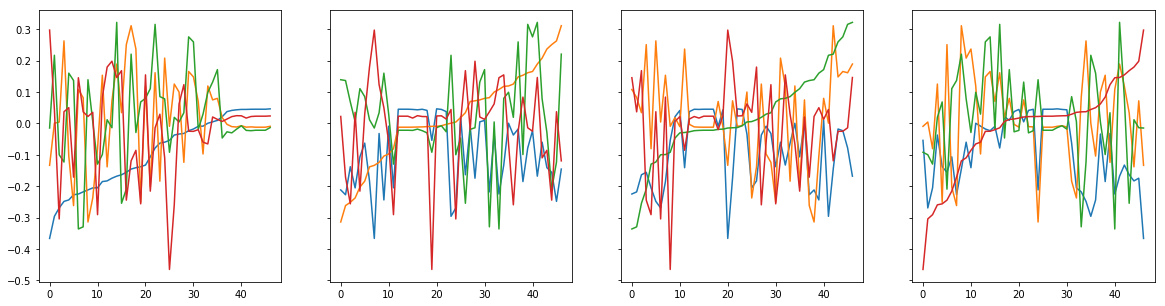

In [183]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
#     print X
    axes[i].plot(X);

In [184]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

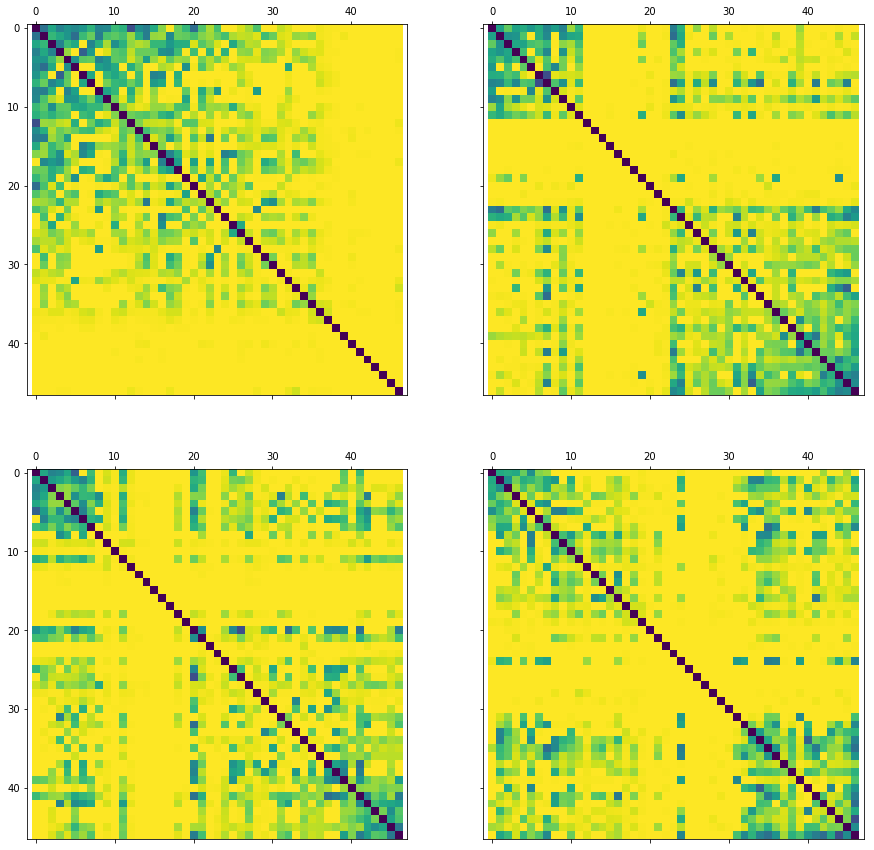

In [185]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
        axes[r,c].matshow(P_norm_reord)
        i+=1

### Explanation and possibe extensions
When we reorder the rows and columns of the matrix using one of the eigenvectors, the grouping of the 
stations becomes more evident. For example, consider the upper left corner of the scond matrix (The upper left one). The stations at positions 0-22 are clearly strongly correlated with each other. Even though there are some stations, in positions 15-18 or so, which are more related to each other than to the rest of this block.

This type of organization is called **Block Diagonal** and it typically reveals important structure such as grouping or clustering.

You might want to extract the sets of stations that form blocks for your region, and then plot them on the map to see their spatial relationship.

In [186]:
from pickle import dump
with open(data_dir+'/TOBS_residuals_PCA.pickle','wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)
    

In [187]:
print pca.components_

[[-0.03369512 -0.24812545  0.0453002  -0.29568656 -0.18290178 -0.05962776
  -0.26900583 -0.15551998 -0.0231738   0.00064752 -0.16345291 -0.18507236
  -0.2116539  -0.14088716 -0.017704   -0.21785186 -0.03684589 -0.17434322
  -0.14523446  0.04152098 -0.22465126  0.04348253 -0.05387159 -0.22702593
  -0.00915066  0.00974127  0.04516891 -0.06261634 -0.20491007  0.04467334
   0.04647999 -0.13780378  0.00512279 -0.07817032  0.04464713 -0.10639093
  -0.13245889 -0.36609188 -0.16786841  0.03765448  0.02146411 -0.00860519
  -0.03188274  0.0453002  -0.24352156  0.0453002  -0.20521091]
 [ 0.10000273  0.2628006  -0.0119541   0.00093109 -0.13827081  0.20799146
   0.004464    0.25098041  0.16544394  0.11933498  0.03423305  0.15351365
  -0.31368542  0.23690825  0.14813711  0.0820664   0.12544441  0.07203591
   0.31112124 -0.0101478   0.10810983 -0.01138361 -0.00915177 -0.26150893
   0.06995637  0.07991799 -0.01098034 -0.18382239 -0.08038009 -0.01180123
  -0.00911047 -0.25108713  0.0749752   0.16141842